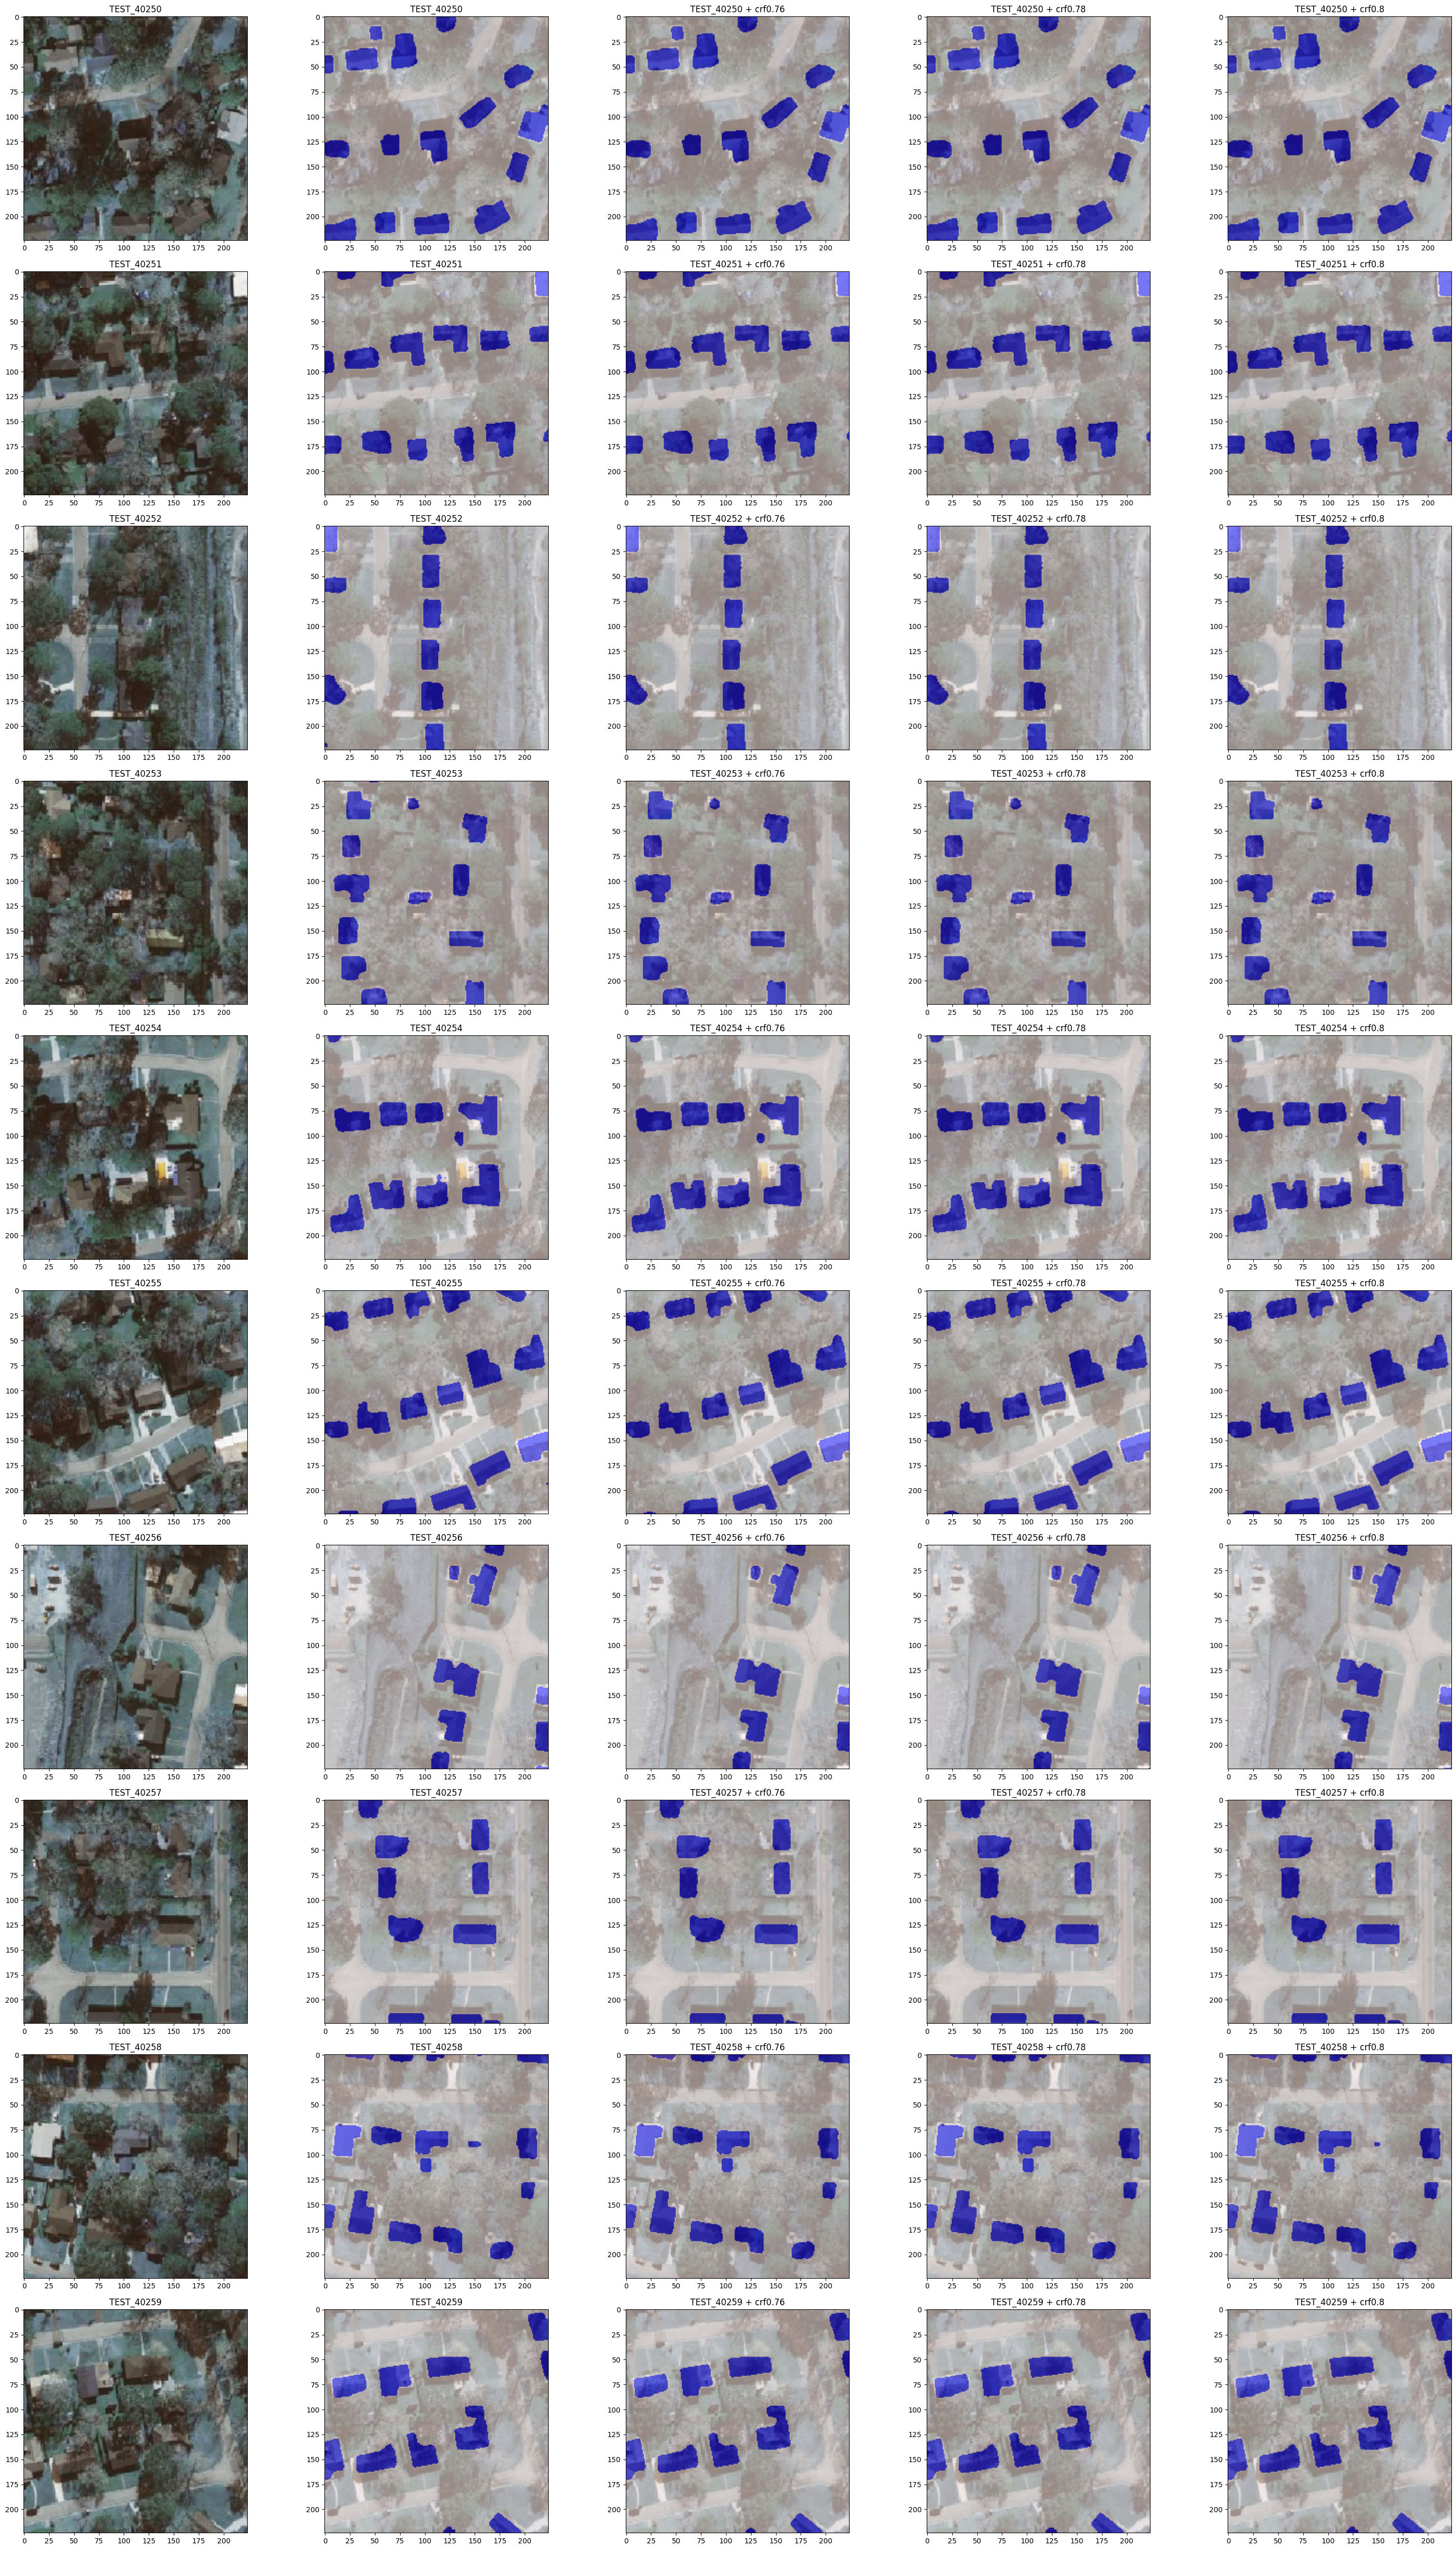

interactive(children=(IntSlider(value=4025, description='idx', max=12075, min=-4025), Output()), _dom_classes=…

In [31]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from tqdm import tqdm
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from ipywidgets import widgets, interact

%matplotlib inline

# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def use_crf(image, mask, crf_steps=10, gt_prob=0.76):
    # Converting annotated image to RGB if it is Gray scale
    annotated_label = mask.flatten()
    if(len(mask.shape)<3):
        mask = gray2rgb(mask)

    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask[:,:,0] + (mask[:,:,1]<<8) + (mask[:,:,2]<<16)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=gt_prob, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for n steps 
    Q = d.inference(crf_steps)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((image.shape[0],image.shape[1]))

csv_file = "/home/jovyan/work/work_space/uijin/util/target_82163.csv"
test_img_dir = "/home/jovyan/work/prj_data/open/test_img"
table = pd.read_csv(csv_file)
palette = np.array([[255, 240, 240], [0, 0, 255]])
num = 10
def visualize(idx):
    fig, ax = plt.subplots(num, 5, figsize=(30, 50))
    plt.clf()
    for i in range(num):
        img_id = table["img_id"][idx*num+i]
        mask_rle = table['mask_rle'][idx*num+i]
        img_path = os.path.join(test_img_dir, img_id + ".png")
        img = cv2.imread(img_path)
        
        plt.subplot(num, 5, 5*i+1)
        plt.title(img_id)
        plt.imshow(img)
        
        mask = rle_decode(mask_rle, (img.shape[0], img.shape[1]))
        mask = palette[mask]
        plt.subplot(num, 5, 5*i+2)
        plt.title(img_id)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        gt_prob = 0.76
        densecrf_mask1 = use_crf(img, mask, gt_prob=gt_prob)
        densecrf_mask1 = palette[densecrf_mask1]
        plt.subplot(num, 5, 5*i+3)
        plt.title(img_id+ " + crf" + str(gt_prob))
        plt.imshow(img)
        plt.imshow(densecrf_mask1, alpha=0.5)
        
        gt_prob = 0.78
        densecrf_mask2 = use_crf(img, mask, gt_prob=gt_prob)
        densecrf_mask2 = palette[densecrf_mask2]
        plt.subplot(num, 5, 5*i+4)
        plt.title(img_id+ " + crf" + str(gt_prob))
        plt.imshow(img)
        plt.imshow(densecrf_mask2, alpha=0.5)
        
        gt_prob = 0.8
        densecrf_mask3 = use_crf(img, mask, gt_prob=gt_prob)
        densecrf_mask3 = palette[densecrf_mask3]
        plt.subplot(num, 5, 5*i+5)
        plt.title(img_id+ " + crf" + str(gt_prob))
        plt.imshow(img)
        plt.imshow(densecrf_mask3, alpha=0.5)
        
    fig.tight_layout()
    plt.show()
    
def main():
    start = 0
    end = len(table['img_id']) // num - 1 
    interact(visualize, idx=4025)#(start, end))
if __name__ == '__main__':
    main()
    
    # 60230
    # 60036
    # 60006
    # 55555
    # 47259
    # 13792 -> 2758
    # 49856 -> 9971

In [ ]:
import os, cv2
import mmcv
import torch
from tqdm import tqdm
from mmseg.apis import init_model, inference_model
from ipywidgets import widgets, interact

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# pred, gt = 없음
# pred O, gt X = [0, 0, 255] 파란색
# pred X, gt O = [255, 0, 0] 빨간색
# pred O, gt O = [0, 255, 0] 녹색

palette = np.array([[0, 0, 0], [0, 0, 255], [255, 0, 0], [0, 255, 0]])
check_num = 10
dice_score_list = []

def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7):
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

def calculate_dice(pred, gt):
    if np.sum(gt) > 0 or np.sum(pred) > 0:
        return dice_score(pred, gt)
    else:
        return None  # No valid masks found, return None

def visualize(idx):
    global dice_score_list, check_num
    fig, ax = plt.subplots(check_num//2, 2, figsize=(30, 30))
    fig.tight_layout()
    plt.clf()
    for i in range(check_num):
        table = dice_score_list[idx*check_num + i]
        img = cv2.imread(table[0])
        mask = table[1]
        mask = palette[mask]
        plt.subplot(check_num // 2, 2, i+1)
        plt.title(os.path.basename(table[0]) + ": " + str(round(table[2], 4)))
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
    plt.show()

def main():
    img_dir = "/home/jovyan/work/datasets/satellite/images/validation"
    anno_dir = "/home/jovyan/work/datasets/satellite/annotations/validation"
    file_name = "deeplabv3p_re"
    config_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/configs', file_name+".py")  
    ckpt_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/ckpts', file_name+".pth")
    device = "cuda:1"
        
        
    model = init_model(config_path, ckpt_path, device)
    img_list = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1] == ".png"]
    # img_list = ["TRAIN_" + f + ".png" for f in ("0948", "2108", "4873", "1092", "5251", "2956", "1251", "4283", "1206", "1848")]
    global dice_score_list
    i = 10
    with torch.no_grad():
        model.eval()
        ratio = 2
        for img_id in tqdm(img_list):
            img_path = os.path.join(img_dir, img_id)
            anno_path = os.path.join(anno_dir, img_id)
            img = cv2.imread(img_path, 1)
            anno = cv2.imread(anno_path, 0)
            resized_img = cv2.resize(img, dsize=(int(img.shape[0]*ratio), int(img.shape[1]*ratio)))
            resized_mask = inference_model(model, resized_img)
            resized_mask = resized_mask.pred_sem_seg.data
            resized_mask = torch.squeeze(resized_mask).cpu().numpy()
            mask = cv2.resize(resized_mask.astype("float32"), dsize=(img.shape[0], img.shape[1])).astype("int32")
            score = calculate_dice(mask, anno)
            mask = 2*anno + mask
            dice_score_list.append((img_path, mask, score))
            # i -= 1
            # if i == 0:
            #     break
    dice_score_list.sort(key = lambda x:x[2])
    
    start = 0
    end = len(img_list) // check_toum - 1 
    interact(visualize, idx=(start, end))
if __name__ == "__main__":
    main()